##### TODO
- some parameters are global(function use the global variables)
- common parameters acquired

## causion
We have to use nipype 1.6.1 and fsl 509(installed by neurodebian). Later version of fsl changed the output of film_gls(or it just not function well in my computer? I will test a docker version)

# main workflow

In [1]:
# import different packages to be needed
from nipype.algorithms.modelgen import SpecifyModel
from nipype.interfaces import fsl
from nipype.interfaces.base import Bunch
from nipype import Workflow, Node, IdentityInterf
ace, Function, DataSink, JoinNode, MapNode
from nipype.algorithms import rapidart

from templateflow.api import get as tpget



import os.path as op
from bids import BIDSLayout

import pandas as pd
from natsort import natsorted, ns # nature sorted
#import logging
import random

220424-17:36:22,306 nipype.utils WARNING:
	 A newer version (1.7.1) of nipy/nipype is available. You are using 1.6.1


In [14]:
# wrap the workflow
def subject_1level(subj, outdir, layout, task, runs):
    print("Now sub " + subj + "'s first level GLM")
    # set up the workflow
    wf = Workflow(name="1level")

    # infosources
    events = layout.get(subject=subj, suffix="events", task=task, return_type="file") # get events file

    print("Found events file in : ")
    print(events)

    infosource = Node(IdentityInterface(fields=['run_id', 'event_file']), name='infosource')
    infosource.iterables = [('run_id', runs),
                            ('event_file', events)]
    infosource.synchronize = True # run and event file will match its sequence


    # data grabber
    def data_grabber(subj, task, fmriprep_dir, run_id):
        """Quick filegrabber ala SelectFiles/DataGrabber"""
        import os.path as op
        from templateflow.api import get as tpget

        prefix = 'sub-{}_task-{}_run-{:01d}'.format(subj, task, run_id)
        fmriprep_func = op.join(fmriprep_dir, "sub-{}".format(subj), "func")

        # grab these files
        confound_file = op.join(fmriprep_func, "{}_desc-confounds_timeseries.tsv".format(prefix)) # newer version of fmriprep changed the counfound tsv file name. 'regressor -> timeseries'
        mni_file = op.join(
            fmriprep_func,
            "{}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold_smooth.nii.gz".format(prefix)
        )
        mni_mask = mni_file.replace("-preproc_bold_smooth.", "-brain_mask.")
        return confound_file, mni_file, mni_mask

    datasource = Node(Function(output_names=["confound_file",
                                             "mni_file",
                                             "mni_mask"],
                               function=data_grabber),
                      name='datasource')

    datasource.inputs.subj = subj
    datasource.inputs.task = task
    datasource.inputs.fmriprep_dir = fmriprep_dir
    wf.connect(infosource, 'run_id', datasource, 'run_id')

    #write realignment parameters in a format that art likes
    def get_mcparams(in_tsv):
        import os
        import pandas as pd
        pd.read_table(in_tsv).to_csv(
            'mcparams.tsv', sep='\t',
            columns=['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'],
            header=False, index=False)
        return os.path.abspath('mcparams.tsv')

    writeparams = Node(Function(output_names=["realignment_params_file"], 
                            function = get_mcparams),
                   name='writeparams')
    wf.connect(datasource, "confound_file", writeparams, "in_tsv")

    #use rapidart to detect outliers in realigned files
    art = Node(rapidart.ArtifactDetect(), name = 'art')
    art.inputs.use_differences = [True, False]
    art.inputs.use_norm = True
    art.inputs.norm_threshold = .4
    art.inputs.zintensity_threshold = 3
    art.inputs.mask_type = 'file'
    art.inputs.plot_type = 'pdf'
    art.inputs.parameter_source = 'SPM' # in the format of SPM, not standing for the real source    

    wf.connect(datasource, "mni_file", art, "realigned_files")
    wf.connect(datasource, "mni_mask", art, "mask_file")
    wf.connect(writeparams, "realignment_params_file", art, "realignment_parameters")

    #     妈的这个写错了，不该这么写    
    #     def add_dummy(outlier_files):
    #         dummy = 4
    #         with open(outlier_files, 'r+') as f:
    #             old_tmp = f.readlines()

    #             for i in range(dummy):
    #                 i=str(i)+'\n'
    #                 if i in old_tmp:
    #                     old_tmp.remove(i)
    #             old = old_tmp
    #             f.seek(0)
    #             f.write('0\n')
    #             f.write('1\n')
    #             f.write('2\n')
    #             f.write('3\n')
    #             f.write(''.join(old))
    #         #return outlier_files
    #     dummy = Node(Function(function=add_dummy), name='add_dummy')
    #     wf.connect(art, 'outlier_files', dummy, 'outlier_files')


    #smooth before running model. 8mm
    # susan was despensed with for fsl6.0 failed to run `fslstats -p`.
    # This procudure was seperately done in the older version see 0susan.ipynb
    # thus the mni_file from inputnode stands for the smoothing file
    # smooth = create_susan_smooth()
    # wf.connect(datasource, "mni_file", smooth, 'inputnode.in_files')
    # smooth.inputs.inputnode.fwhm = 8
    # wf.connect(datasource, "mni_mask", smooth, 'inputnode.mask_file')

    # subject info
    def gen_model_info(event_file, confound_file, regressor_names):
        #    """Defines `SpecifyModel` information from BIDS events."""
        import pandas as pd
        from nipype.interfaces.base import Bunch

        # experimental stimulus
        events = pd.read_csv(event_file, sep="\t")
        trial_types = events.trial_type.unique()
        onset = []
        duration = []
        for trial in trial_types:
            onset.append(events[events.trial_type == trial].onset.tolist())
            duration.append(events[events.trial_type == trial].duration.tolist())

        # confounding variables
        confounds = pd.read_csv(confound_file, sep="\t", na_values="n/a")
        regressors = []
        for regressor in regressor_names:
            if regressor == 'framewise_displacement':
                regressors.append(confounds[regressor].fillna(0))
            else:
                regressors.append(confounds[regressor])

        # constructing the returning data structure
        info = [Bunch(
            conditions=trial_types,
            onsets=onset,
            durations=duration,
            regressors=regressors,
            regressor_names=regressor_names,
        )]
        return info

    modelinfo = Node(Function(function=gen_model_info), name="modelinfo")
    modelinfo.inputs.regressor_names = ['framewise_displacement',
                                        'rot_x', 'rot_y', 'rot_z',
                                        'trans_x', 'trans_y', 'trans_z',
                                        'csf', 'white_matter'] 
    wf.connect(infosource, "event_file", modelinfo, "event_file")
    wf.connect(datasource, "confound_file", modelinfo, "confound_file")

    modelspec = Node(SpecifyModel(), name="modelspec")

    modelspec.inputs.input_units = "secs"
    modelspec.inputs.time_repetition = TR
    modelspec.inputs.high_pass_filter_cutoff = 100.
    modelspec.inputs.parameter_source = 'SPM'
    wf.connect(modelinfo, "out", modelspec, "subject_info")
    wf.connect(datasource, "mni_file", modelspec, "functional_runs")
    wf.connect(art, 'outlier_files', modelspec, 'outlier_files')

    def gen_model_info(event_file, confound_file, regressor_names):
        #    """Defines `SpecifyModel` information from BIDS events."""
        import pandas as pd
        from nipype.interfaces.base import Bunch

        # experimental stimulus
        events = pd.read_csv(event_file, sep="\t")
        trial_types = events.trial_type.unique()
        onset = []
        duration = []
        for trial in trial_types:
            onset.append(events[events.trial_type == trial].onset.tolist())
            duration.append(events[events.trial_type == trial].duration.tolist())

        # confounding variables
        confounds = pd.read_csv(confound_file, sep="\t", na_values="n/a")
        regressors = []
        for regressor in regressor_names:
            if regressor == 'framewise_displacement':
                regressors.append(confounds[regressor].fillna(0))
            else:
                regressors.append(confounds[regressor])

        # constructing the returning data structure
        info = [Bunch(
            conditions=trial_types,
            onsets=onset,
            durations=duration,
            regressors=regressors,
            regressor_names=regressor_names,
        )]
        return info

        if not contrasts:
            raise AttributeError("No contrasts found for task {}".format(task))
        return contrasts

    def read_contrasts(bids_dir, task):
        """potential BUG? This will not update if contrasts file is changed."""
        import os.path as op

        condition_names = []
        contrasts = []

        contrasts_file = op.join(bids_dir, "code", "contrasts.tsv")
        if not op.exists(contrasts_file):
            raise FileNotFoundError("Contrasts file not found.")
        with open(contrasts_file, "r") as fp:
            info = [line.strip().split("\t") for line in fp.readlines()]

        for row in info:
            if row[0] != task:
                continue

            contrasts.append([
                row[1],
                "T",
                [cond for cond in row[2].split(" ")],
                [float(w) for w in row[3].split(" ")]
            ])
        if not contrasts:
            raise AttributeError("No contrasts found for task {}".format(task))
            
        print(contrasts)
        return contrasts

    contrastgen = Node(Function(output_names=["contrasts"],
                                function=read_contrasts),
                       name="contrastgen")

    contrastgen.inputs.bids_dir = bids_dir
    contrastgen.inputs.task = task

    level1design = Node(fsl.Level1Design(), name="level1design")
    level1design.inputs.interscan_interval = TR
    level1design.inputs.bases = {"dgamma": {"derivs": True}}
    level1design.inputs.model_serial_correlations = True
    wf.connect(modelspec, "session_info", level1design, "session_info")
    wf.connect(contrastgen, "contrasts", level1design, "contrasts")

    masker = MapNode(fsl.ApplyMask(), name="masker", iterfield=['in_file'])
    wf.connect(datasource, "mni_mask", masker, "mask_file")
    wf.connect(datasource, "mni_file", masker, "in_file") # mask the susan_smoothed file

    modelgen = Node(fsl.FEATModel(), name="modelgen")
    wf.connect(level1design, "fsf_files", modelgen, "fsf_file")
    wf.connect(level1design, "ev_files", modelgen, "ev_files")

    glm = MapNode(fsl.FILMGLS(), name="filmgls", iterfield=['in_file'])
    glm.inputs.mask_size = 8
    glm.inputs.smooth_autocorr = True
    wf.connect(masker, "out_file", glm, "in_file")
    wf.connect(modelgen, "design_file", glm, "design_file")
    wf.connect(modelgen, "con_file", glm, "tcon_file")
    wf.connect(modelgen, "fcon_file", glm, "fcon_file")

    def substitutes(contrasts):
        """Datasink output path substitutes"""
        subs = []
        for i, con in enumerate(contrasts,1):
            # replace annoying chars in filename
            name = con[0].replace(" ", "").replace(">", "_gt_").lower()

            subs.append(('/cope%d.' % i, '/con_%d_%s_cope.' % (i,name)))
            subs.append(('/varcope%d.' % i, '/con_%d_%s_varcope.' % (i,name)))
            subs.append(('/zstat%d.' % i, '/con_%d_%s_zstat.' % (i, name)))
            subs.append(('/tstat%d.' % i, '/con_%d_%s_tstat.' % (i, name)))
            subs.append(('/_filmgls0/', '/'))
        return subs

    gensubs = Node(Function(function=substitutes), name="substitute_gen")
    wf.connect(contrastgen, "contrasts", gensubs, "contrasts")

    sinker = Node(DataSink(), name="datasink")
    sinker.inputs.base_directory = outdir
    sinker.inputs.regexp_substitutions = [("_event_file.*run_id_", "run"),
                                          ("model/sub.*_run-", "model/run"),
                                          ("_bold_space-MNI","/MNI"),
                                          ("_space-MNI","/MNI")]


    wf.connect(gensubs, "out", sinker, "substitutions")
    wf.connect(modelgen, "design_file", sinker, "design.@design_file")
    wf.connect(modelgen, "con_file", sinker, "design.@tcon_file")
    wf.connect(modelgen, "design_cov", sinker, "design.@cov")
    wf.connect(modelgen, "design_image", sinker, "design.@design")
    wf.connect(glm, "copes", sinker, "model.@copes")
    wf.connect(glm, "dof_file", sinker, "model.@dof")
    wf.connect(glm, "logfile", sinker, "model.@log")
    wf.connect(glm, "param_estimates", sinker, "model.@pes")
    wf.connect(glm, "residual4d", sinker, "model.@res")
    wf.connect(glm, "sigmasquareds", sinker, "model.@ss")
    wf.connect(glm, "thresholdac", sinker, "model.@thresh")
    wf.connect(glm, "tstats", sinker, "model.@tstats")
    wf.connect(glm, "varcopes", sinker, "model.@varcopes")
    wf.connect(glm, "zstats", sinker, "model.@zstats")
    wf.connect(datasource, "mni_mask", sinker, "model.@mask_file")
    return wf

# load configuration

In [38]:
def read_contrasts(bids_dir, task):
    """potential BUG? This will not update if contrasts file is changed."""
    import os
    from os.path import join as opj
    import numpy as np

    condition_names = []
    contrasts = []

    contrasts_file = opj(bids_dir, "code", "contrasts.tsv")
    if not os.path.exists(contrasts_file):
        raise FileNotFoundError("Contrasts file not found.")
    with open(contrasts_file, "r") as fp:
        info = [line.strip().split("\t") for line in fp.readlines()]

    for row in info:
        if row[0] != task:
            continue
        contrasts.append([
            row[1],
            "T",
            [cond for cond in row[2].split(" ")],
            [float(w) for w in row[3].split(" ")]
        ])
    if not contrasts:
        raise AttributeError("No contrasts found for task {}".format(task))

    return np.array(contrasts)

In [41]:
contrasts = read_contrasts(bids_dir, task)[:,0]

/tmp/ipykernel_20562/2618209857.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(contrasts)


In [45]:
for i, contrast in enumerate(contrasts,1):
    print(i)
    print(type(i))
    print(contrast)

1
<class 'int'>
reading-decoding
2
<class 'int'>
decoding-rest


In [17]:
constrasts[:,0]

array(['reading-decoding', 'decoding-rest'], dtype=object)

In [5]:
import conf
conf.load()
info = conf.read("level1")

layout, work_dir, bids_dir, task, runs, out_dir, fmriprep_dir, conf_dir, TR, level1_dir, level2_dir, level3_dir, sub_list, indvar_dir = list(info.values())

*** Load level1.
*** In this analysis:
    	 * Working directory: /tmp/work
    	 * BIDS directory: /media/seven/file/reading/Nifti
    	 * Output directory: /media/seven/file/reading/Nifti/derivatives/glm/level1
    	 * fMRIPrep directory(validated): /media/seven/file/reading/Nifti/derivatives/fmriprep
    	 * Configuration directory: /media/seven/file/reading/Nifti/code/00-conf
    	 * Task: sentence
    	 * Runs: [1, 2]
    	 * TR: 2s
    	 * 1st level directory: /media/seven/file/reading/Nifti/derivatives/glm/level1
    	 * 2nd level directory: /media/seven/file/reading/Nifti/derivatives/glm/level2
    	 * 3rd level directory: /media/seven/file/reading/Nifti/derivatives/glm/level3
    	 * individual differences directory: /media/seven/file/reading/Nifti/derivatives/glm/indvar
    	 * Subjects: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '

In [5]:
# if you need choose subjects instead of the whole subjects in BIDS
#sub_list = range(67,141)
#sub_list = [str(i) for i in sub_list]

print("Subject list: ")
print(sub_list)
# 10 failed ???

Subject list: 
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140']


# Main function

In [11]:
sub_l = arange(3,141)
sub_l = [str(i) for i in sub_l]

'/media/seven/file/reading/Nifti/derivatives/glm/level1/sub-140/text'

In [15]:
for sub in ['3']:
    sub_out = op.join(out_dir, 'sub-' + sub, task)
    wf = subject_1level(sub, sub_out, conf.layout, task, runs)
    wf.base_dir = op.join(work_dir, 'sub-'+sub)
    wf.run(plugin="MultiProc", plugin_args={'n_procs': 8})

Now sub 3's first level GLM
Found events file in : 
['/media/seven/file/reading/Nifti/sub-3/func/sub-3_task-sentence_run-1_events.tsv', '/media/seven/file/reading/Nifti/sub-3/func/sub-3_task-sentence_run-2_events.tsv']
220424-21:14:08,30 nipype.workflow INFO:
	 Workflow 1level settings: ['check', 'execution', 'logging', 'monitoring']
220424-21:14:08,39 nipype.workflow INFO:
	 Running in parallel.
220424-21:14:08,40 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 28.03/28.03, Free processors: 8/8.
220424-21:14:08,101 nipype.workflow INFO:
	 [Node] Outdated cache found for "1level.contrastgen".
220424-21:14:08,107 nipype.workflow INFO:
	 [Job 1] Cached (1level.datasource).
220424-21:14:08,107 nipype.workflow INFO:
	 [Node] Setting-up "1level.contrastgen" in "/tmp/work/sub-3/1level/contrastgen".
220424-21:14:08,108 nipype.workflow INFO:
	 [Node] Outdated cache found for "1level.contrastgen".
220424-21:14:08,109 nipype.workflow INFO:
	 [Job 2] Cache

Below is the test code seperating the whole codes into some pieces.

In [7]:
! which film_gls

/usr/local/fsl/bin/film_gls


In [45]:
# wrap the workflow
subj = '2'
out_dir = op.join(out_dir, 'sub-' + subj, task)
layout = conf.layout
task = task
runs = runs
outdir = op.join(out_dir, 'sub-' + subj, task)

print("Now sub " + subj + "'s first level GLM")
# set up the workflow
wf = Workflow(name="1level")

# infosources
events = layout.get(subject=subj, suffix="events", task=task, return_type="file") # get events file

print("Found events file in : ")
print(events)

infosource = Node(IdentityInterface(fields=['run_id', 'event_file']), name='infosource')
infosource.iterables = [('run_id', runs),
                        ('event_file', events)]
infosource.synchronize = True # run and event file will match its sequence


# data grabber
def data_grabber(subj, task, fmriprep_dir, run_id):
    """Quick filegrabber ala SelectFiles/DataGrabber"""
    import os.path as op
    from templateflow.api import get as tpget

    prefix = 'sub-{}_task-{}_run-{:01d}'.format(subj, task, run_id)
    fmriprep_func = op.join(fmriprep_dir, "sub-{}".format(subj), "func")

    # grab these files
    confound_file = op.join(fmriprep_func, "{}_desc-confounds_timeseries.tsv".format(prefix)) # newer version of fmriprep changed the counfound tsv file name. 'regressor -> timeseries'
    mni_file = op.join(
        fmriprep_func,
        "{}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold_smooth.nii.gz".format(prefix)
    )
    mni_mask = mni_file.replace("-preproc_bold_smooth.", "-brain_mask.")
    return confound_file, mni_file, mni_mask

datasource = Node(Function(output_names=["confound_file",
                                         "mni_file",
                                         "mni_mask"],
                           function=data_grabber),
                  name='datasource')

datasource.inputs.subj = subj
datasource.inputs.task = task
datasource.inputs.fmriprep_dir = fmriprep_dir
wf.connect(infosource, 'run_id', datasource, 'run_id')

#write realignment parameters in a format that art likes
def get_mcparams(in_tsv):
    import os
    import pandas as pd
    pd.read_table(in_tsv).to_csv(
        'mcparams.tsv', sep='\t',
        columns=['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'],
        header=False, index=False)
    return os.path.abspath('mcparams.tsv')

writeparams = Node(Function(output_names=["realignment_params_file"], 
                        function = get_mcparams),
               name='writeparams')
wf.connect(datasource, "confound_file", writeparams, "in_tsv")

#use rapidart to detect outliers in realigned files
art = Node(rapidart.ArtifactDetect(), name = 'art')
art.inputs.use_differences = [True, False]
art.inputs.use_norm = True
art.inputs.norm_threshold = .4
art.inputs.zintensity_threshold = 3
art.inputs.mask_type = 'file'
art.inputs.plot_type = 'pdf'
art.inputs.parameter_source = 'SPM' # in the format of SPM, not standing for the real source    

wf.connect(datasource, "mni_file", art, "realigned_files")
wf.connect(datasource, "mni_mask", art, "mask_file")
wf.connect(writeparams, "realignment_params_file", art, "realignment_parameters")

#     妈的这个写错了，不该这么写    
#     def add_dummy(outlier_files):
#         dummy = 4
#         with open(outlier_files, 'r+') as f:
#             old_tmp = f.readlines()

#             for i in range(dummy):
#                 i=str(i)+'\n'
#                 if i in old_tmp:
#                     old_tmp.remove(i)
#             old = old_tmp
#             f.seek(0)
#             f.write('0\n')
#             f.write('1\n')
#             f.write('2\n')
#             f.write('3\n')
#             f.write(''.join(old))
#         #return outlier_files
#     dummy = Node(Function(function=add_dummy), name='add_dummy')
#     wf.connect(art, 'outlier_files', dummy, 'outlier_files')


#smooth before running model. 8mm
# susan was despensed with for fsl6.0 failed to run `fslstats -p`.
# This procudure was seperately done in the older version see 0susan.ipynb
# thus the mni_file from inputnode stands for the smoothing file
# smooth = create_susan_smooth()
# wf.connect(datasource, "mni_file", smooth, 'inputnode.in_files')
# smooth.inputs.inputnode.fwhm = 8
# wf.connect(datasource, "mni_mask", smooth, 'inputnode.mask_file')

# subject info
def gen_model_info(event_file, confound_file, regressor_names):
    #    """Defines `SpecifyModel` information from BIDS events."""
    import pandas as pd
    from nipype.interfaces.base import Bunch

    # experimental stimulus
    events = pd.read_csv(event_file, sep="\t")
    trial_types = events.trial_type.unique()
    onset = []
    duration = []
    for trial in trial_types:
        onset.append(events[events.trial_type == trial].onset.tolist())
        duration.append(events[events.trial_type == trial].duration.tolist())

    # confounding variables
    confounds = pd.read_csv(confound_file, sep="\t", na_values="n/a")
    regressors = []
    for regressor in regressor_names:
        if regressor == 'framewise_displacement':
            regressors.append(confounds[regressor].fillna(0))
        else:
            regressors.append(confounds[regressor])

    # constructing the returning data structure
    info = [Bunch(
        conditions=trial_types,
        onsets=onset,
        durations=duration,
        regressors=regressors,
        regressor_names=regressor_names,
    )]
    return info

modelinfo = Node(Function(function=gen_model_info), name="modelinfo")
modelinfo.inputs.regressor_names = ['framewise_displacement',
                                    'rot_x', 'rot_y', 'rot_z',
                                    'trans_x', 'trans_y', 'trans_z',
                                    'csf', 'white_matter'] 
wf.connect(infosource, "event_file", modelinfo, "event_file")
wf.connect(datasource, "confound_file", modelinfo, "confound_file")

modelspec = Node(SpecifyModel(), name="modelspec")

modelspec.inputs.input_units = "secs"
modelspec.inputs.time_repetition = TR
modelspec.inputs.high_pass_filter_cutoff = 100.
modelspec.inputs.parameter_source = 'SPM'
wf.connect(modelinfo, "out", modelspec, "subject_info")
wf.connect(datasource, "mni_file", modelspec, "functional_runs")
wf.connect(art, 'outlier_files', modelspec, 'outlier_files')

def gen_model_info(event_file, confound_file, regressor_names):
    #    """Defines `SpecifyModel` information from BIDS events."""
    import pandas as pd
    from nipype.interfaces.base import Bunch

    # experimental stimulus
    events = pd.read_csv(event_file, sep="\t")
    trial_types = events.trial_type.unique()
    onset = []
    duration = []
    for trial in trial_types:
        onset.append(events[events.trial_type == trial].onset.tolist())
        duration.append(events[events.trial_type == trial].duration.tolist())

    # confounding variables
    confounds = pd.read_csv(confound_file, sep="\t", na_values="n/a")
    regressors = []
    for regressor in regressor_names:
        if regressor == 'framewise_displacement':
            regressors.append(confounds[regressor].fillna(0))
        else:
            regressors.append(confounds[regressor])

    # constructing the returning data structure
    info = [Bunch(
        conditions=trial_types,
        onsets=onset,
        durations=duration,
        regressors=regressors,
        regressor_names=regressor_names,
    )]
    return info

    if not contrasts:
        raise AttributeError("No contrasts found for task {}".format(task))
    return contrasts

def read_contrasts(bids_dir, task):
    """potential BUG? This will not update if contrasts file is changed."""
    import os.path as op

    condition_names = []
    contrasts = []

    contrasts_file = op.join(bids_dir, "code", "contrasts.tsv")
    if not op.exists(contrasts_file):
        raise FileNotFoundError("Contrasts file not found.")
    with open(contrasts_file, "r") as fp:
        info = [line.strip().split("\t") for line in fp.readlines()]

    for row in info:
        if row[0] != task:
            continue

        contrasts.append([
            row[1],
            "T",
            [cond for cond in row[2].split(" ")],
            [float(w) for w in row[3].split(" ")]
        ])
    if not contrasts:
        raise AttributeError("No contrasts found for task {}".format(task))
    return contrasts

contrastgen = Node(Function(output_names=["contrasts"],
                            function=read_contrasts),
                   name="contrastgen")

contrastgen.inputs.bids_dir = bids_dir
contrastgen.inputs.task = task

level1design = MapNode(fsl.Level1Design(), name="level1design", iterfield=['contrasts'])
level1design.inputs.interscan_interval = TR
level1design.inputs.bases = {"dgamma": {"derivs": True}}
level1design.inputs.model_serial_correlations = True
wf.connect(modelspec, "session_info", level1design, "session_info")
wf.connect(contrastgen, "contrasts", level1design, "contrasts")

masker = MapNode(fsl.ApplyMask(), name="masker", iterfield=['in_file'])
wf.connect(datasource, "mni_mask", masker, "mask_file")
wf.connect(datasource, "mni_file", masker, "in_file") # mask the susan_smoothed file

modelgen = Node(fsl.FEATModel(), name="modelgen")
wf.connect(level1design, "fsf_files", modelgen, "fsf_file")
wf.connect(level1design, "ev_files", modelgen, "ev_files")

glm = MapNode(fsl.FILMGLS(), name="filmgls", iterfield=['in_file'])
glm.inputs.mask_size = 8
glm.inputs.smooth_autocorr = True
wf.connect(masker, "out_file", glm, "in_file")
wf.connect(modelgen, "design_file", glm, "design_file")
wf.connect(modelgen, "con_file", glm, "tcon_file")
wf.connect(modelgen, "fcon_file", glm, "fcon_file")

def substitutes(contrasts):
    """Datasink output path substitutes"""
    subs = []
    for i, con in enumerate(contrasts,1):
        # replace annoying chars in filename
        name = con[0].replace(" ", "").replace(">", "_gt_").lower()

        subs.append(('/cope%d.' % i, '/con_%d_%s_cope.' % (i,name)))
        subs.append(('/varcope%d.' % i, '/con_%d_%s_varcope.' % (i,name)))
        subs.append(('/zstat%d.' % i, '/con_%d_%s_zstat.' % (i, name)))
        subs.append(('/tstat%d.' % i, '/con_%d_%s_tstat.' % (i, name)))
        subs.append(('/_filmgls0/', '/'))
    return subs

gensubs = Node(Function(function=substitutes), name="substitute_gen")
wf.connect(contrastgen, "contrasts", gensubs, "contrasts")

sinker = Node(DataSink(), name="datasink")
sinker.inputs.base_directory = outdir
sinker.inputs.regexp_substitutions = [("_event_file.*run_id_", "run"),
                                      ("model/sub.*_run-", "model/run"),
                                      ("_bold_space-MNI","/MNI"),
                                      ("_space-MNI","/MNI")]


wf.connect(gensubs, "out", sinker, "substitutions")
wf.connect(modelgen, "design_file", sinker, "design.@design_file")
wf.connect(modelgen, "con_file", sinker, "design.@tcon_file")
wf.connect(modelgen, "design_cov", sinker, "design.@cov")
wf.connect(modelgen, "design_image", sinker, "design.@design")
wf.connect(glm, "copes", sinker, "model.@copes")
wf.connect(glm, "dof_file", sinker, "model.@dof")
wf.connect(glm, "logfile", sinker, "model.@log")
wf.connect(glm, "param_estimates", sinker, "model.@pes")
wf.connect(glm, "residual4d", sinker, "model.@res")
wf.connect(glm, "sigmasquareds", sinker, "model.@ss")
wf.connect(glm, "thresholdac", sinker, "model.@thresh")
wf.connect(glm, "tstats", sinker, "model.@tstats")
wf.connect(glm, "varcopes", sinker, "model.@varcopes")
wf.connect(glm, "zstats", sinker, "model.@zstats")
wf.connect(datasource, "mni_mask", sinker, "model.@mask_file")

Now sub 2's first level GLM
Found events file in : 
['/media/seven/file/reading/Nifti/sub-2/func/sub-2_task-sentence_run-1_events.tsv', '/media/seven/file/reading/Nifti/sub-2/func/sub-2_task-sentence_run-2_events.tsv']


In [46]:
wf.run()

220424-17:32:45,831 nipype.workflow INFO:
	 Workflow 1level settings: ['check', 'execution', 'logging', 'monitoring']
220424-17:32:45,844 nipype.workflow INFO:
	 Running serially.
220424-17:32:45,845 nipype.workflow INFO:
	 [Node] Setting-up "1level.contrastgen" in "/tmp/tmp8ijfsg8y/1level/contrastgen".
220424-17:32:45,846 nipype.workflow INFO:
	 [Node] Running "contrastgen" ("nipype.interfaces.utility.wrappers.Function")
220424-17:32:45,849 nipype.workflow INFO:
	 [Node] Finished "1level.contrastgen".
220424-17:32:45,849 nipype.workflow INFO:
	 [Node] Setting-up "1level.datasource" in "/tmp/tmp95u5g_qp/1level/_event_file_..media..seven..file..reading..Nifti..sub-2..func..sub-2_task-sentence_run-1_events.tsv_run_id_1/datasource".
220424-17:32:45,851 nipype.workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.utility.wrappers.Function")
220424-17:32:45,853 nipype.workflow INFO:
	 [Node] Finished "1level.datasource".
220424-17:32:45,853 nipype.workflow INFO:
	 [Node] Setting-

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


220424-17:33:13,116 nipype.workflow INFO:
	 [Node] Finished "1level.art".
220424-17:33:13,117 nipype.workflow INFO:
	 [Node] Setting-up "1level.art" in "/tmp/tmp_h6limns/1level/_event_file_..media..seven..file..reading..Nifti..sub-2..func..sub-2_task-sentence_run-2_events.tsv_run_id_2/art".
220424-17:33:13,120 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
220424-17:33:15,838 nipype.workflow INFO:
	 [Node] Finished "1level.art".
220424-17:33:15,839 nipype.workflow INFO:
	 [Node] Setting-up "1level.modelspec" in "/tmp/tmpflq2x82o/1level/_event_file_..media..seven..file..reading..Nifti..sub-2..func..sub-2_task-sentence_run-1_events.tsv_run_id_1/modelspec".
220424-17:33:15,860 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifyModel")
220424-17:33:15,885 nipype.workflow INFO:
	 [Node] Finished "1level.modelspec".
220424-17:33:15,885 nipype.workflow INFO:
	 [Node] Setting-up "1level.modelspec" in "/tmp/tmp5rdwt

RuntimeError: Workflow did not execute cleanly. Check log for details

In [42]:
def substitutes(contrasts):
    """Datasink output path substitutes"""
    subs = []
    for i, con in enumerate(contrasts,1):
        # replace annoying chars in filename
        name = con[0].replace(" ", "").replace(">", "_gt_").lower()

        subs.append(('/cope%d.' % i, '/con_%d_%s_cope.' % (i,name)))
        subs.append(('/varcope%d.' % i, '/con_%d_%s_varcope.' % (i,name)))
        subs.append(('/zstat%d.' % i, '/con_%d_%s_zstat.' % (i, name)))
        subs.append(('/tstat%d.' % i, '/con_%d_%s_tstat.' % (i, name)))
        subs.append(('/_filmgls0/', '/'))
    return subs
substitutes(contrasts)


[('/cope1.', '/con_1_reading-decoding_cope.'),
 ('/varcope1.', '/con_1_reading-decoding_varcope.'),
 ('/zstat1.', '/con_1_reading-decoding_zstat.'),
 ('/tstat1.', '/con_1_reading-decoding_tstat.'),
 ('/_filmgls0/', '/'),
 ('/cope2.', '/con_2_decoding-rest_cope.'),
 ('/varcope2.', '/con_2_decoding-rest_varcope.'),
 ('/zstat2.', '/con_2_decoding-rest_zstat.'),
 ('/tstat2.', '/con_2_decoding-rest_tstat.'),
 ('/_filmgls0/', '/')]

In [41]:
for i, con in enumerate(contrasts,1):
    print(i)
    print(con)

1
['reading-decoding', 'T', ['reading', 'decoding', 'rest'], [1.0, -1.0, 0.0]]
2
['decoding-rest', 'T', ['reading', 'decoding', 'rest'], [0.0, 1.0, -1.0]]


# Explaination over Code

First, we shall the take a look on the workflow:

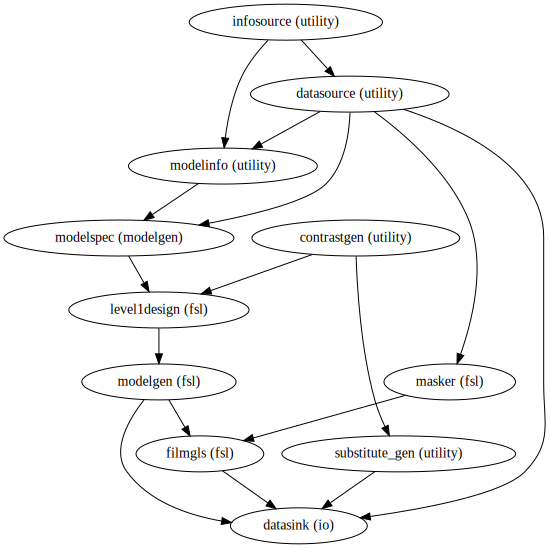

In [1]:
from IPython.display import SVG
SVG('fsl_glm/first_wf.svg')

Among these operations, followings are the most important nodes:
- `modelgen`: generate the model
- `level1design`:
- ``
- `filmgls`: Uses FSL feat_model to generate design.mat files

In [ ]:
modelspec = Node(SpecifyModel(), name="modelspec")

modelspec.inputs.input_units = "secs"
modelspec.inputs.time_repetition = TR
modelspec.inputs.high_pass_filter_cutoff = 100.
modelspec.inputs.parameter_source = 'FSL'
wf_1level.connect(modelinfo, "out", modelspec, "subject_info")
wf_1level.connect(datasource, "mni_file", modelspec, "functional_runs")

def read_contrasts(bids_dir, task):
    """potential BUG? This will not update if contrasts file is changed."""
    import os.path as op
    condition_names = ['reading', 'decoding', 'rest']

    contrasts = [('reading-decoding', 'T', condition_names, [1, -1, 0]),
                 ('decoding-rest', 'T', condition_names, [0, 1, -1])]

    ## TODO

    # contrasts_file = op.join(bids_dir, "code", "contrasts.tsv")
    # if not op.exists(contrasts_file):
    #     raise FileNotFoundError("Contrasts file not found.")
    # with open(contrasts_file, "r") as fp:
    #     info = [line.strip().split("\t") for line in fp.readlines()]

    # for row in info:
    #     if row[0] != task:
    #         continue

    #     contrasts.append([
    #         row[1],
    #         "T",
    #         [cond for cond in row[2].split(" ")],
    #         [float(w) for w in row[3].split(" ")]
    #     ])

    if not contrasts:
        raise AttributeError("No contrasts found for task {}".format(task))
    return contrasts

contrastgen = Node(Function(output_names=["contrasts"],
                            function=read_contrasts),
                   name="contrastgen")
contrastgen.inputs.bids_dir = bids_dir
contrastgen.inputs.task = task

level1design = Node(fsl.Level1Design(), name="level1design")
level1design.inputs.interscan_interval = TR
level1design.inputs.bases = {"dgamma": {"derivs": True}}
level1design.inputs.model_serial_correlations = True
wf_1level.connect(modelspec, "session_info", level1design, "session_info")
wf_1level.connect(contrastgen, "contrasts", level1design, "contrasts")

wf_1level.run()



In [ ]:
# masker = MapNode(fsl.ApplyMask(), name="masker", iterfield=['in_file'])
# wf_1level.connect(datasource, "mni_mask", masker, "mask_file")
# wf_1level.connect(datasource, "mni_file", masker, "in_file")

# modelgen = Node(fsl.FEATModel(), name="modelgen")
# wf_1level.connect(level1design, "fsf_files", modelgen, "fsf_file")
# wf_1level.connect(level1design, "ev_files", modelgen, "ev_files")

# glm = MapNode(fsl.FILMGLS(), name="filmgls", iterfield=['in_file'])
# glm.inputs.mask_size = 6
# glm.inputs.smooth_autocorr = True
# wf_1level.connect(masker, "out_file", glm, "in_file")
# wf_1level.connect(modelgen, "design_file", glm, "design_file")
# wf_1level.connect(modelgen, "con_file", glm, "tcon_file")
# wf_1level.connect(modelgen, "fcon_file", glm, "fcon_file")

# def substitutes(contrasts):
#     """Datasink output path substitutes"""
#     subs = []
#     for i, con in enumerate(contrasts,1):
#         # replace annoying chars in filename
#         name = con[0].replace(" ", "").replace(">", "_gt_").lower()

#         subs.append(('/cope%d.' % i, '/con_%d_%s_cope.' % (i,name)))
#         subs.append(('/varcope%d.' % i, '/con_%d_%s_varcope.' % (i,name)))
#         subs.append(('/zstat%d.' % i, '/con_%d_%s_zstat.' % (i, name)))
#         subs.append(('/tstat%d.' % i, '/con_%d_%s_tstat.' % (i, name)))
#         subs.append(('/_filmgls0/', '/'))
#     return subs

# gensubs = Node(Function(function=substitutes), name="substitute_gen")
# wf_1level.connect(contrastgen, "contrasts", gensubs, "contrasts")

# sinker = Node(DataSink(), name="datasink")
# sinker.inputs.base_directory = outdir
# sinker.inputs.regexp_substitutions = [("_event_file.*run_id_", "run"),
#                                       ("model/sub.*_run-", "model/run"),
#                                       ("_bold_space-MNI","/MNI"),
#                                       ("_space-MNI","/MNI")]


# wf_1level.connect(gensubs, "out", sinker, "substitutions")
# wf_1level.connect(modelgen, "design_file", sinker, "design.@design_file")
# wf_1level.connect(modelgen, "con_file", sinker, "design.@tcon_file")
# wf_1level.connect(modelgen, "design_cov", sinker, "design.@cov")
# wf_1level.connect(modelgen, "design_image", sinker, "design.@design")
# wf_1level.connect(glm, "copes", sinker, "model.@copes")
# wf_1level.connect(glm, "dof_file", sinker, "model.@dof")
# wf_1level.connect(glm, "logfile", sinker, "model.@log")
# wf_1level.connect(glm, "param_estimates", sinker, "model.@pes")
# wf_1level.connect(glm, "residual4d", sinker, "model.@res")
# wf_1level.connect(glm, "sigmasquareds", sinker, "model.@ss")
# wf_1level.connect(glm, "thresholdac", sinker, "model.@thresh")
# wf_1level.connect(glm, "tstats", sinker, "model.@tstats")
# wf_1level.connect(glm, "varcopes", sinker, "model.@varcopes")
# wf_1level.connect(glm, "zstats", sinker, "model.@zstats")
# wf_1level.connect(datasource, "mni_mask", sinker, "model.@mask_file")

# wf_1level.run()